In [1]:
#读取数据
import pandas as pd
df = pd.read_excel('./Table_CR_version2.xlsx')
df.head()

,Secondary phase,grain size,Abweichung,texture,products layer,chloride,pH,deformation degree,twins,LAGB,Immersion time (h),CR
0,0.0,131.4,76.0,NaN,NaN,115.7,NaN,NaN,NaN,NaN,5,0.83
1,0.5,24.7,9.8,NaN,NaN,115.7,NaN,NaN,NaN,NaN,5,0.92
2,10.3,9.5,3.6,NaN,NaN,115.7,NaN,NaN,NaN,NaN,5,1.43
3,0.0,131.4,76.0,NaN,NaN,115.7,NaN,NaN,NaN,NaN,24,0.27
4,0.5,24.7,9.8,NaN,NaN,115.7,NaN,NaN,NaN,NaN,24,0.31


In [2]:
#填充空值
df = df.fillna(0)
df.head()

,Secondary phase,grain size,Abweichung,texture,products layer,chloride,pH,deformation degree,twins,LAGB,Immersion time (h),CR
0,0.0,131.4,76.0,0.0,0.0,115.7,0.0,0.0,0.0,0.0,5,0.83
1,0.5,24.7,9.8,0.0,0.0,115.7,0.0,0.0,0.0,0.0,5,0.92
2,10.3,9.5,3.6,0.0,0.0,115.7,0.0,0.0,0.0,0.0,5,1.43
3,0.0,131.4,76.0,0.0,0.0,115.7,0.0,0.0,0.0,0.0,24,0.27
4,0.5,24.7,9.8,0.0,0.0,115.7,0.0,0.0,0.0,0.0,24,0.31


In [3]:
#获得原始数据
X = df.values[:,:11]
y = df.values[:,-1]
print(X.shape,y.shape,'\n',X[0])

(149, 11) (149,) 
 [  0.  131.4  76.    0.    0.  115.7   0.    0.    0.    0.    5. ]


In [4]:
#对数据进行归一化
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() #实例化
X = scaler.fit_transform(X)
print(X[0])

[0.         0.14372122 0.39767673 0.         0.         0.18967213
 0.         0.         0.         0.         0.        ]


In [5]:
from sklearn.model_selection import train_test_split
#数据集划分
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=10)

# XGBoost

In [6]:
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import cross_val_score
#模型训练
xgbr = XGBRegressor()
scores = cross_val_score(xgbr, x_train, y_train, cv=10) #采用10折交叉验证
print(scores)

[  0.45700835 -62.80455404  -0.18814501   0.83326372   0.32708807
 -10.25339689 -38.96832348   0.73931727   0.11930079   0.96133711]


In [7]:
from sklearn import metrics
xgbr.fit(x_train,y_train)
xgbr.save_model('./models/xgboost_model.model') #模型保存
y_pred=xgbr.predict(x_test)  #得到预测后的y值 验证测试集的x值
mae=metrics.mean_absolute_error(y_test, y_pred)
mae #测试集合的mae值指标

1.2630512460784227

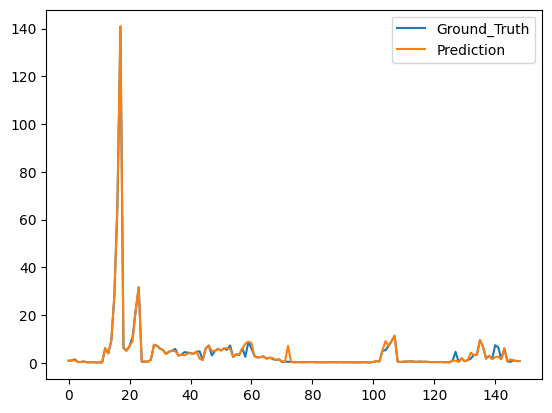

In [8]:
#训练及测试预测曲线
%matplotlib inline
import matplotlib.pyplot as plt
pred = xgbr.predict(X)
plt.plot(range(len(X)),y,label='Ground_Truth')
plt.plot(range(len(X)),pred,label='Prediction')
plt.legend()
plt.show()

In [9]:
import shap
explainer = shap.TreeExplainer(xgbr,X)
shap_values = explainer.shap_values(X)  # 传入特征矩阵X，计算SHAP值
shap_values

array([[-0.43571268,  0.90172769, -0.54662799, ...,  0.        ,
         0.        ,  0.53607879],
       [-0.28465828, -0.1138505 , -0.00985094, ...,  0.        ,
         0.        ,  0.52620292],
       [ 0.32293446, -0.2817275 ,  0.04076542, ...,  0.        ,
         0.        ,  0.58828872],
       ...,
       [-0.66431456, -0.74209905,  0.04833518, ...,  0.        ,
         0.        ,  0.11671535],
       [-0.6593342 , -0.61597954,  0.04833518, ...,  0.        ,
         0.        ,  0.1177827 ],
       [-0.6593342 , -0.58894972,  0.04833518, ...,  0.        ,
         0.        ,  0.1177827 ]])

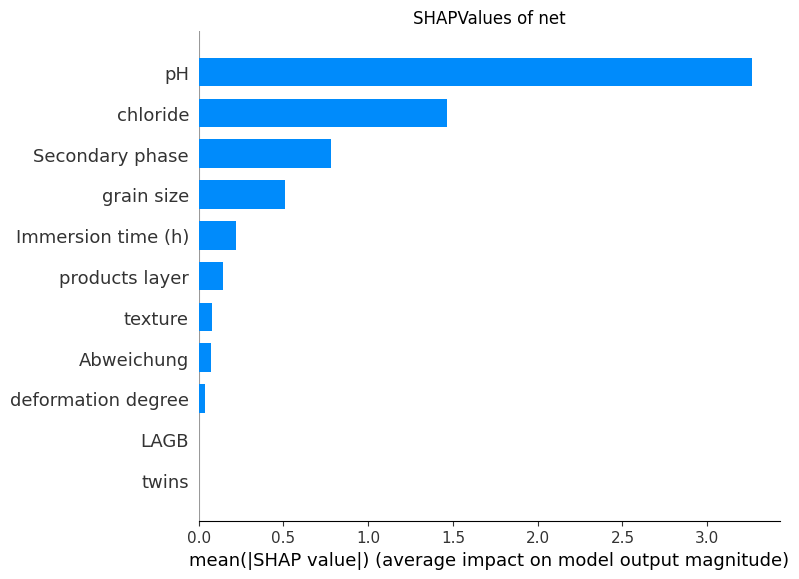

In [10]:
#绘图，柱状图，最大展示特征数max_display=40
plt.title('SHAPValues of net')
shap.summary_plot(shap_values, df.columns, plot_type="bar", max_display=40)
plt.show()

 # 高斯过程贝叶斯优化

In [11]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
#模型训练
gb = linear_model.BayesianRidge()
scores = cross_val_score(gb, x_train, y_train, cv=10) #采用10折交叉验证
print(scores)

[ -8.2273871   -5.56997662  -2.35354408  -7.81821854   0.16379061
  -0.02665752 -20.42651015  -9.93374541   0.44932036  -0.03327663]


In [12]:
import joblib
gb.fit(x_train,y_train)
joblib.dump(gb, './models/gb.model') #模型保存
# gb = joblib.load('./modesl/gb.model')
y_pred=gb.predict(x_test)  #得到预测后的y值 验证测试集的x值
mae=metrics.mean_absolute_error(y_test, y_pred)
mae #测试集合的mae值指标

4.6780165661148665

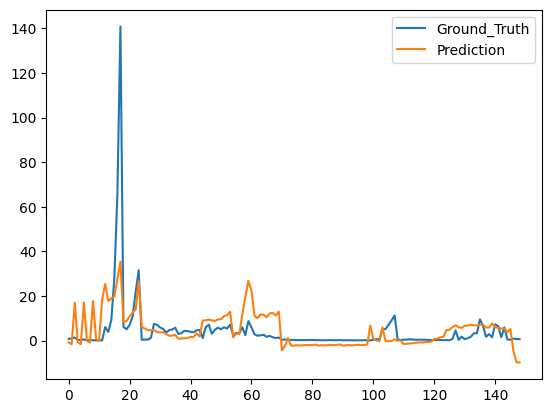

In [13]:
#训练及测试预测曲线
pred = gb.predict(X)
plt.plot(range(len(X)),y,label='Ground_Truth')
plt.plot(range(len(X)),pred,label='Prediction')
plt.legend()
plt.show()

In [14]:
explainer = shap.LinearExplainer(gb,X)
shap_values = explainer.shap_values(X)  # 传入特征矩阵X，计算SHAP值
shap_values

array([[-2.10941822e+00,  1.67119028e+00, -2.90233470e-01, ...,
        -3.59222967e-02, -5.01416266e-02, -9.11440326e-01],
       [-1.14183069e+00, -4.45568876e-01, -1.40082091e-02, ...,
        -3.59222967e-02, -5.01416266e-02, -9.11440326e-01],
       [ 1.78228849e+01, -7.47112824e-01,  1.18618304e-02, ...,
        -3.59222967e-02, -5.01416266e-02, -9.11440326e-01],
       ...,
       [-2.10941822e+00, -8.56224121e-01,  2.68831436e-02, ...,
        -3.59222967e-02, -5.01416266e-02, -1.42272461e-01],
       [-2.10941822e+00, -8.64159488e-01,  2.68831436e-02, ...,
        -3.59222967e-02, -5.01416266e-02, -1.42272461e-01],
       [-2.10941822e+00, -8.70111013e-01,  2.68831436e-02, ...,
        -3.59222967e-02, -5.01416266e-02, -1.42272461e-01]])

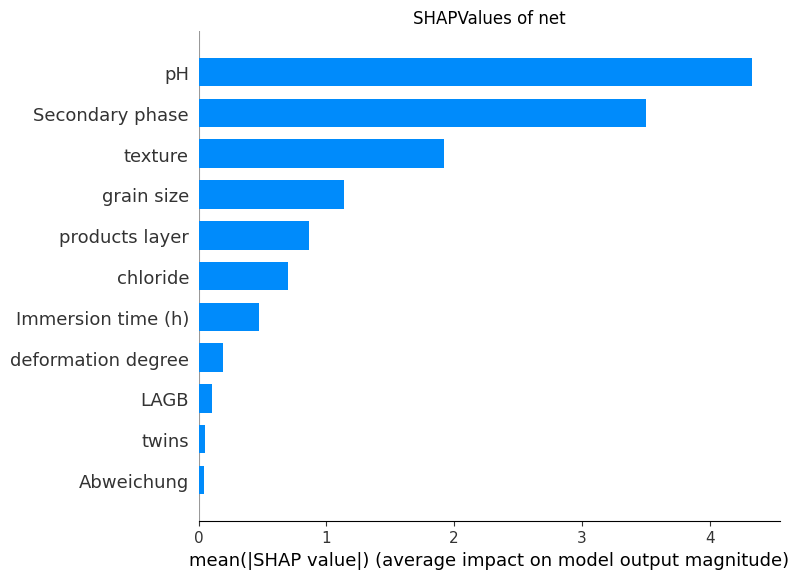

In [15]:
#绘图，柱状图，最大展示特征数max_display=40
plt.title('SHAPValues of net')
shap.summary_plot(shap_values, df.columns, plot_type="bar", max_display=40)
plt.show()

# 贝叶斯神经网络

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

class Linear_BBB(nn.Module):
    """
        Layer of our BNN.
    """
    def __init__(self, input_features, output_features, prior_var=1.):
        """
            Initialization of our layer : our prior is a normal distribution
            centered in 0 and of variance 20.
        """
        # initialize layers
        super().__init__()
        # set input and output dimensions
        self.input_features = input_features
        self.output_features = output_features
 
        # initialize mu and rho parameters for the weights of the layer
        self.w_mu = nn.Parameter(torch.zeros(output_features, input_features))
        self.w_rho = nn.Parameter(torch.zeros(output_features, input_features))
 
        #initialize mu and rho parameters for the layer's bias
        self.b_mu =  nn.Parameter(torch.zeros(output_features))
        self.b_rho = nn.Parameter(torch.zeros(output_features))        
 
        #initialize weight samples (these will be calculated whenever the layer makes a prediction)
        self.w = None
        self.b = None
 
        # initialize prior distribution for all of the weights and biases
        self.prior = torch.distributions.Normal(0,prior_var)
 
    def forward(self, input):
        """
          Optimization process
        """
        # sample weights
        w_epsilon = Normal(0,1).sample(self.w_mu.shape)
        self.w = self.w_mu + torch.log(1+torch.exp(self.w_rho)) * w_epsilon
 
        # sample bias
        b_epsilon = Normal(0,1).sample(self.b_mu.shape)
        self.b = self.b_mu + torch.log(1+torch.exp(self.b_rho)) * b_epsilon
 
        # record log prior by evaluating log pdf of prior at sampled weight and bias
        w_log_prior = self.prior.log_prob(self.w)
        b_log_prior = self.prior.log_prob(self.b)
        self.log_prior = torch.sum(w_log_prior) + torch.sum(b_log_prior)
 
        # record log variational posterior by evaluating log pdf of normal distribution defined by parameters with respect at the sampled values
        self.w_post = Normal(self.w_mu.data, torch.log(1+torch.exp(self.w_rho)))
        self.b_post = Normal(self.b_mu.data, torch.log(1+torch.exp(self.b_rho)))
        self.log_post = self.w_post.log_prob(self.w).sum() + self.b_post.log_prob(self.b).sum()
 
        return F.linear(input, self.w, self.b)
 
class MLP_BBB(nn.Module):
    def __init__(self, hidden_units, noise_tol=.1,  prior_var=1.):
 
        # initialize the network like you would with a standard multilayer perceptron, but using the BBB layer
        super().__init__()
        self.hidden = Linear_BBB(11,hidden_units, prior_var=prior_var)
        self.out = Linear_BBB(hidden_units, 1, prior_var=prior_var)
        self.noise_tol = noise_tol # we will use the noise tolerance to calculate our likelihood
 
    def forward(self, x):
        # again, this is equivalent to a standard multilayer perceptron
        x = torch.sigmoid(self.hidden(x))
        x = self.out(x)
        return x
 
    def log_prior(self):
        # calculate the log prior over all the layers
        return self.hidden.log_prior + self.out.log_prior
 
    def log_post(self):
        # calculate the log posterior over all the layers
        return self.hidden.log_post + self.out.log_post
 
    def sample_elbo(self, input, target, samples):
        # we calculate the negative elbo, which will be our loss function
        #initialize tensors
        outputs = torch.zeros(samples, target.shape[0])
        log_priors = torch.zeros(samples)
        log_posts = torch.zeros(samples)
        log_likes = torch.zeros(samples)
        # make predictions and calculate prior, posterior, and likelihood for a given number of samples
        for i in range(samples):
            outputs[i] = self(input).reshape(-1) # make predictions
            log_priors[i] = self.log_prior() # get log prior
            log_posts[i] = self.log_post() # get log variational posterior
            log_likes[i] = Normal(outputs[i], self.noise_tol).log_prob(target.reshape(-1)).sum() # calculate the log likelihood
        # calculate monte carlo estimate of prior posterior and likelihood
        log_prior = log_priors.mean()
        log_post = log_posts.mean()
        log_like = log_likes.mean()
        # calculate the negative elbo (which is our loss function)
        loss = log_post - log_prior - log_like
        return loss
 
def toy_function(x):
    return -x**4 + 3*x**2 + 1
 

net = MLP_BBB(32, prior_var=10)
optimizer = optim.Adam(net.parameters(), lr=.1)
epochs = 1000
x_train,y_train = torch.Tensor(x_train),torch.Tensor(y_train)
for epoch in range(epochs):  # loop over the dataset multiple times
    optimizer.zero_grad()
    # forward + backward + optimize
    
    loss = net.sample_elbo(x_train, y_train, 1)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print('epoch: {}/{}'.format(epoch+1,epochs))
        print('Loss:', loss.item())
print('Finished Training')
torch.save(net,'./models/bynn.pth')

epoch: 1/1000
Loss: 1334170.875
epoch: 11/1000
Loss: 1258078.875
epoch: 21/1000
Loss: 1217896.125
epoch: 31/1000
Loss: 1222758.375
epoch: 41/1000
Loss: 1071333.75
epoch: 51/1000
Loss: 960459.9375
epoch: 61/1000
Loss: 925632.375
epoch: 71/1000
Loss: 790374.125
epoch: 81/1000
Loss: 674265.25
epoch: 91/1000
Loss: 585266.4375
epoch: 101/1000
Loss: 509561.03125
epoch: 111/1000
Loss: 413396.46875
epoch: 121/1000
Loss: 352627.28125
epoch: 131/1000
Loss: 305117.78125
epoch: 141/1000
Loss: 245942.125
epoch: 151/1000
Loss: 208505.578125
epoch: 161/1000
Loss: 175247.3125
epoch: 171/1000
Loss: 155684.296875
epoch: 181/1000
Loss: 128514.375
epoch: 191/1000
Loss: 107457.390625
epoch: 201/1000
Loss: 89250.5703125
epoch: 211/1000
Loss: 75842.8828125
epoch: 221/1000
Loss: 62606.75390625
epoch: 231/1000
Loss: 59102.73828125
epoch: 241/1000
Loss: 57280.734375
epoch: 251/1000
Loss: 60261.0234375
epoch: 261/1000
Loss: 48787.28515625
epoch: 271/1000
Loss: 40135.76953125
epoch: 281/1000
Loss: 35025.09375
epo

In [17]:
x_test = torch.Tensor(x_test)
y_pred=net(x_test)  #得到预测后的y值 验证测试集的x值
mae=metrics.mean_absolute_error(y_test, y_pred.detach().numpy())
mae #测试集合的mae值指标

1.4267050592867234

In [18]:
explainer = shap.DeepExplainer(net,torch.Tensor(X))
shap_values = explainer.shap_values(torch.Tensor(X))  # 传入特征矩阵X，计算SHAP值
shap_values

array([[-4.57697392e+00,  5.59833574e+00, -4.83920097e+00, ...,
        -5.16744889e-03,  3.35459039e-02,  4.83282879e-02],
       [-3.85063028e+00, -1.09474766e+00,  4.44715828e-01, ...,
        -5.05557377e-03,  2.48962529e-02, -2.28182189e-02],
       [ 9.05107784e+00, -2.15651250e+00,  9.53987896e-01, ...,
        -2.93659326e-03,  2.63751056e-02,  1.28806541e-02],
       ...,
       [-4.51904249e+00, -2.46555018e+00,  1.23234177e+00, ...,
        -5.39527740e-03,  2.46454254e-02,  2.28624389e-01],
       [-4.50850868e+00, -2.48797679e+00,  1.23564112e+00, ...,
        -4.89191152e-03,  3.36216390e-02,  1.90735906e-01],
       [-4.62865353e+00, -2.49594164e+00,  1.24762249e+00, ...,
        -4.88392892e-04,  3.24660130e-02,  1.99799091e-01]])

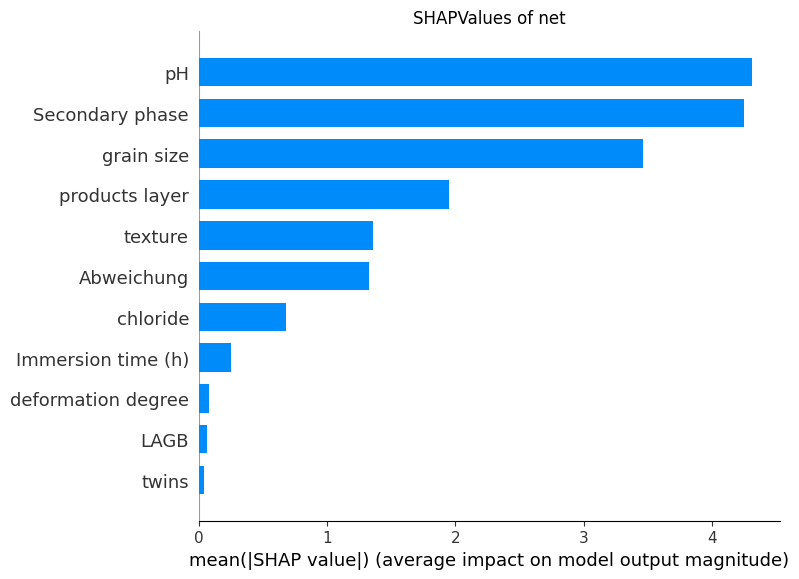

In [19]:
#绘图，柱状图，最大展示特征数max_display=40
plt.title('SHAPValues of net')
shap.summary_plot(shap_values, df.columns, plot_type="bar", max_display=40)
plt.show()